### Anchor Selection

The problem of choosing the ”most similar” k anchor shapes can be formulated as the following: given a set of ground truth bounding box shape observations {(wi , hi)}, find k anchors such that the sum of the distance (in the shape space of (width, height)) between each ground truth box to its nearest anchor is minimized. This problem can be effectively solved by K-means. The optimal anchor shapes are plotted in Fig. 3(b). These anchors are optimized specifically for the car category, but the idea of optimizing anchors by considering ground truth bounding box statistics can be generalized to multi-category object detection as well.

In [1]:
import cv2
import os 
import numpy as np
import json
from collections import namedtuple
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D
import math
from matplotlib import cm
from math import sqrt, floor
import sklearn.preprocessing
from sklearn.cluster import KMeans

In [2]:
Label = namedtuple( 'Label' , [

    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name a class

    'id'          , # An integer ID that is associated with this label.
                    # The IDs are used to represent the label in ground truth images
                    # An ID of -1 means that this label does not have an ID and thus
                    # is ignored when creating ground truth images (e.g. license plate).
                    # Do not modify these IDs, since exactly these IDs are expected by the
                    # evaluation server.

    'trainId'     , # Feel free to modify these IDs as suitable for your method. Then create
                    # ground truth images with train IDs, using the tools provided in the
                    # 'preparation' folder. However, make sure to validate or submit results
                    # to our evaluation server using the regular IDs above!
                    # For trainIds, multiple labels might have the same ID. Then, these labels
                    # are mapped to the same class in the ground truth images. For the inverse
                    # mapping, we use the label that is defined first in the list below.
                    # For example, mapping all void-type classes to the same ID in training,
                    # might make sense for some approaches.
                    # Max value is 255!

    'category'    , # The name of the category that this label belongs to

    'categoryId'  , # The ID of this category. Used to create ground truth images
                    # on category level.

    'hasInstances', # Whether this label distinguishes between single instances or not

    'ignoreInEval', # Whether pixels having this class as ground truth label are ignored
                    # during evaluations or not

    'color'       , # The color of this label
    ] )

labels = [
    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label(  'unlabeled'            ,  0 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'ego vehicle'          ,  1 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'rectification border' ,  2 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'out of roi'           ,  3 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'static'               ,  4 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'dynamic'              ,  5 ,      255 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    Label(  'ground'               ,  6 ,      255 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    Label(  'road'                 ,  7 ,        0 , 'flat'            , 1       , False        , False        , (128, 64,128) ),
    Label(  'sidewalk'             ,  8 ,        1 , 'flat'            , 1       , False        , False        , (244, 35,232) ),
    Label(  'parking'              ,  9 ,      255 , 'flat'            , 1       , False        , True         , (250,170,160) ),
    Label(  'rail track'           , 10 ,      255 , 'flat'            , 1       , False        , True         , (230,150,140) ),
    Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),
    Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label(  'guard rail'           , 14 ,      255 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    Label(  'bridge'               , 15 ,      255 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    Label(  'tunnel'               , 16 ,      255 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    Label(  'polegroup'            , 18 ,      255 , 'object'          , 3       , False        , True         , (153,153,153) ),
    Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),
    Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    Label(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    Label(  'caravan'              , 29 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    Label(  'trailer'              , 30 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    Label(  'license plate'        , -1 ,       -1 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),
    ]

In [3]:
name2label      = { label.name    : label for label in labels           }
# id to label object
id2label        = { label.id      : label for label in labels           }
# trainId to label object
trainId2label   = { label.trainId : label for label in reversed(labels) }

def _load_image_set_idx(_image_set):
    image_set_file = os.path.join(
        r"D:\leftImg8bit_trainvaltest\leftImg8bit", 'ImageSets', _image_set+'.txt')
    assert os.path.exists(image_set_file), \
        'File does not exist: {}'.format(image_set_file)
    with open(image_set_file) as f:
        image_idx = [x.strip() for x in f.readlines()]
    return image_idx

def get_8_point_mask_parameterization(polygon, height, width):
    outline = np.array(polygon)
    rrr, ccc = outline[:,1], outline[:,0]
    rr = []
    cc = []
    for r in rrr:
        if r < 0:
            r = 0
        if r > height:
            r = height
        rr.append(r)
    for c in ccc:
        if c < 0:
            c = 0
        if c > width:
            c = width
        cc.append(c)
    rr = np.array(rr)
    cc = np.array(cc)
    sum_values = cc + rr
    diff_values = cc - rr
    xmin = max(min(cc), 0)
    xmax = min(max(cc), width)
    ymin = max(min(rr), 0)
    ymax = min(max(rr), height)
    width       = xmax - xmin
    height      = ymax - ymin
    center_x  = xmin + 0.5*width 
    center_y  = ymin + 0.5*height
    center = (center_x, center_y)
    min_sum_indices = np.where(sum_values == np.amin(sum_values))[0][0]
    pt_p_min = (cc[min_sum_indices], rr[min_sum_indices])
    max_sum_indices = np.where(sum_values == np.amax(sum_values))[0][0]
    pt_p_max = (cc[max_sum_indices], rr[max_sum_indices])
    min_diff_indices = np.where(diff_values == np.amin(diff_values))[0][0]
    pt_n_min = (cc[min_diff_indices], rr[min_diff_indices])
    max_diff_indices = np.where(diff_values == np.amax(diff_values))[0][0]
    pt_n_max = (cc[max_diff_indices], rr[max_diff_indices])
    pts = [pt_p_min, pt_n_min, pt_p_max, pt_n_max]
    mask_vector = [xmin, ymin, xmax, ymax, pts[0], pts[1], pts[2], pts[3], center_x, center_y, width, height]
    return mask_vector

In [4]:
def assureSingleInstance(name, reject_groups=False):
    # if the name is known, it is not a group
    if name in name2label:
        return name2label[name], name
    # test if the name actually denotes a group
    if not reject_groups:
        if not name.endswith("group"):
            return None, None
        # remove group
        name = name[:-len("group")]
        # test if the new name exists
        if not name in name2label:
            return None, None
        return name2label[name], name
    else:
        return None, None
    
def get_statistics_without_object_groups(data_split):
    permitted_classes = ['person', 'rider', 'car', 'truck', 'bus', 'motorcycle', 'bicycle']
    path_var = data_split
#     if data_split == 'train':
#         path_var = 'training'
    _image_idx = _load_image_set_idx(data_split)
    total_artifacts = []
    counter = {}
    for index in _image_idx:
        artifacts = []
        filename = os.path.join(r"D:\leftImg8bit_trainvaltest\leftImg8bit",path_var,"instance", index[:-11]+'gtFine_polygons.json')
        with open(filename) as f:
            data_dict = json.load(f)
            imgHeight = data_dict['imgHeight']
            imgWidth = data_dict['imgWidth']
            instances = data_dict['objects']
            for instance in instances:
                class_name = instance['label']
                params, modified_name = assureSingleInstance(class_name, True)
                if params != None and params.hasInstances and modified_name in permitted_classes:
                    if class_name in counter:
                        counter[class_name] += 1
                    else:
                        counter[class_name] = 1
                    polygon = np.array(instance['polygon'])
                    vector = get_8_point_mask_parameterization(polygon, imgHeight, imgWidth) 
                    xmin, ymin, xmax, ymax, of1, of2, of3, of4, of5, of6, of7, of8 = vector
                    assert xmin >= 0.0 and xmin <= xmax, \
                        'Invalid bounding box x-coord xmin {} or xmax {} at {}.txt' \
                            .format(xmin, xmax, index)
                    assert ymin >= 0.0 and ymin <= ymax, \
                        'Invalid bounding box y-coord ymin {} or ymax {} at {}.txt' \
                            .format(ymin, ymax, index)
                    w = xmax-xmin
                    h = ymax-ymin
                    artifacts.append([w, h, class_name, xmin+(w/2), ymin+(h/2)])
        total_artifacts.append(artifacts)
    print("Number of artifacts found for datasplit ", data_split, ": ", len(total_artifacts))
    return total_artifacts, counter, imgWidth, imgHeight

In [5]:
# Naive sharding initialization for k-means clustering
# Implementation adapted from https://www.kdnuggets.com/2017/03/naive-sharding-centroid-initialization-method.html
def naive_sharding(ds, k):
    """
    Create cluster centroids using deterministic naive sharding algorithm.
    
    Parameters
    ----------
    ds : numpy array
        The dataset to be used for centroid initialization.
    k : int
        The desired number of clusters for which centroids are required.

    Returns
    -------
    centroids : numpy array
        Collection of k centroids as a numpy array.
    """
    
    n = np.shape(ds)[1]
    m = np.shape(ds)[0]
    centroids = np.mat(np.zeros((k,n)))

    # Sum all elements of each row, add as col to original dataset, sort
    composite = np.mat(np.sum(ds, axis=1))
    ds = np.append(composite.T, ds, axis=1)
    ds.sort(axis=0)

    # Step value for dataset sharding
    step = floor(m/k)

    # Vectorize mean ufunc for numpy array
    vfunc = np.vectorize(_get_mean)

    # Divide matrix rows equally by k-1 (so that there are k matrix shards)
    # Sum columns of shards, get means; these columnar means are centroids
    for j in range(k):
        if j == k-1:
            centroids[j:] = vfunc(np.sum(ds[j*step:,1:], axis=0), step)
        else:
            centroids[j:] = vfunc(np.sum(ds[j*step:(j+1)*step,1:], axis=0), step)

    return centroids

def _get_mean(sums, step):
    """
    Vectorizable ufunc for getting means of summed shard columns.
    
    Parameters
    ----------
    sums : float
        The summed shard columns.
    step : int
        The number of instances per shard.

    Returns
    -------
    sums/step (means) : numpy array
        The means of the shard columns.
    """

    return sums/step

In [6]:
def filter_artifacts(total_artifacts, threshold, plot_dist=True):
    reshaped_total_artifacts = []
    width_less_than = {}
    height_less_than = {}
    for artifacts in total_artifacts:
        for artifact in artifacts:
            flag1 = True
            flag2 = True
            if artifact[0] < threshold:
                flag1 = False
                l = artifact[2]
                if l not in width_less_than:
                    width_less_than[l] = 1
                else:
                    width_less_than[l] += 1
            if artifact[1] < threshold:
                flag2 = False
                l = artifact[2]
                if l not in height_less_than:
                    height_less_than[l] = 1
                else:
                    height_less_than[l] += 1
            if flag1 and flag2:
                reshaped_total_artifacts.append(artifact)
    if plot_dist:
        fig, axs = plt.subplots(1,2,figsize=(20,10))
        fig.suptitle('Outlier distribution ', y=0.92, fontsize = 18)
        axs[0].scatter(width_less_than.keys(), width_less_than.values())
        axs[0].set_ylabel('Number of occurrence')
        axs[0].set_xlabel('Class')
        axs[1].scatter(height_less_than.keys(), height_less_than.values())
        axs[1].set_ylabel('Number of occurrence')
        axs[1].set_xlabel('Class')
        axs[0].grid()
        axs[1].grid()
        plt.show()
    return reshaped_total_artifacts, width_less_than, height_less_than
    
def find_anchors(total_artifacts, imgW, imH, k, width_scale = 0.5, height_scale = 0.5, debug=False, old_anchors=[], thresh=10):
    if len(old_anchors) == 0:
        reshaped_total_artifacts, width_less_than, height_less_than = filter_artifacts(total_artifacts, threshold=thresh, plot_dist=False)
        reshaped_train_total_artifacts = np.asarray(reshaped_total_artifacts)
        widths = reshaped_train_total_artifacts[:,0]
        heights = reshaped_train_total_artifacts[:,1]
        widths = widths.astype(np.float)
        heights = heights.astype(np.float)
        
        #First rescale for down/upsampling
        widths = np.multiply(widths, width_scale) 
        heights = np.multiply(heights, height_scale)

        fig = plt.figure(figsize=(15,10))
        plt.scatter(widths, heights, alpha=0.9, c='r', s=20, label='Ground-truth boxes', edgecolors='k')
        plt.ylabel('Heights')
        plt.xlabel('Widths')
        # plt.xlim(-20,2100)
        # plt.ylim(-10,1050)
        plt.legend()
        plt.grid()
        plt.title("Object heights vs Object widths")
        
        # Scale dataset for normalization for K-means
        widths = np.divide(widths, imgW*width_scale) 
        heights = np.divide(heights, imH*height_scale)
        X = np.vstack((widths, heights)).T
#         print(np.shape(X))

        X_scaled = X

        # Use naive sharding to generate initial centroids
        centroids_scaled = naive_sharding(X_scaled, k)
        if debug:
            print('Centroids using naive sharding (scaled data)')
            print('--------------------------------------------')
            print(centroids_scaled)

        model_ns = KMeans(n_clusters=k, init=centroids_scaled, n_init=1)
        model_ns.fit(X_scaled)
        if debug:
            print('Predicted')
            print('---------')
            print(model_ns.labels_,'\n')
            print(model_ns.cluster_centers_)
        
        # Rescale the dataset to get back in the normal down/up sampled range
        widths = np.multiply(widths, imgW*width_scale) 
        heights = np.multiply(heights, imH*height_scale)
        
        fig = plt.figure(figsize=(15,10))
        # Plot the decision boundary. For that, we will assign a color to each
        h = 1 
        x_min, x_max = widths.min() - 20, widths.max() + 20
        y_min, y_max = heights.min() - 20, heights.max() + 20
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

        # Obtain labels for each point in mesh. Use last trained model.
        # Re-Normalize the data to ensure the k-means predictor works
        Z = model_ns.predict(np.c_[np.divide(xx.ravel(), imgW*width_scale), np.divide(yy.ravel(), imH*height_scale)])
        print("Before Rescaling", model_ns.cluster_centers_)
        new_anchors = model_ns.cluster_centers_
        new_anchors[:,0] = new_anchors[:,0]*imgW*width_scale
        new_anchors[:,1] = new_anchors[:,1]*imH*height_scale
        print("After Rescaling", model_ns.cluster_centers_)
        
        print("\nExtracted Anchors")
        print(new_anchors)
        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        print(np.unique(Z))
        plt.clf()
        plt.title(str(k)+" anchor boxes extracted using k-means clustering ")
        plt.imshow(Z, interpolation='nearest',
                   extent=(xx.min(), xx.max(), yy.min(), yy.max()),
                   cmap=plt.cm.twilight,
                   aspect='auto', origin='lower')
        plt.scatter(widths, heights, alpha=0.6, c='r', s=20, label='Ground-truth boxes')
        colors = cm.twilight(np.linspace(0, 1, k))
        for i, anchor in enumerate(new_anchors):
            plt.scatter(anchor[0], anchor[1], alpha=1, s=200, marker='X', label='ANCHOR '+str(i+1), color=colors[i], edgecolors='k')

        plt.ylabel('Heights')
        plt.xlabel('Widths')
        plt.xlim(x_min,x_max)
        plt.ylim(y_min,y_max)
        plt.legend()
        plt.grid()
        distance_list = []
        for i, anchor in enumerate(new_anchors):
            X = np.vstack((np.log(widths), np.log(heights))).T
            cluster_points = X[model_ns.labels_ == i]
            anchor = np.log(np.reshape(anchor, (1,2)))
            diffs = cluster_points-anchor
            distances = np.linalg.norm(diffs, axis=1)
#             print(np.shape(distances))
            distance_list.extend(distances)
        log_dist = np.sum(distance_list)
        print("Total Distance in log domain:", log_dist)
        distance_list = []
        for i, anchor in enumerate(new_anchors):
            X = np.vstack((widths, heights)).T
            cluster_points = X[model_ns.labels_ == i]
            anchor = np.reshape(anchor, (1,2))
            diffs = cluster_points-anchor
            distances = np.linalg.norm(diffs, axis=1)
#             print(np.shape(distances))
            distance_list.extend(distances)
    else:
        reshaped_total_artifacts, width_less_than, height_less_than = filter_artifacts(total_artifacts, threshold=thresh, plot_dist=False)
        reshaped_train_total_artifacts = np.asarray(reshaped_total_artifacts)
        widths = reshaped_train_total_artifacts[:,0]
        widths = widths.astype(np.float)
        heights = reshaped_train_total_artifacts[:,1]
        heights = heights.astype(np.float)
        # Only for plotting
        widths = np.multiply(widths, width_scale) 
        heights = np.multiply(heights, height_scale)
        X = np.vstack((widths, heights)).T
        new_anchors = old_anchors
        labels = []
        distance_list = []
        for i, pt in enumerate(X):
            dist = np.linalg.norm(np.log(new_anchors) - np.log(pt), axis=1)
#            Euclidean distance alternative
#             dist = np.square(new_anchors - pt)
#             dist = np.sum(dist, axis=1)
#             dist = np.sqrt(dist)
            l = np.argmin(dist)
            labels.append(l)
            distance_list.append(dist[l])
        log_dist = np.sum(distance_list)
        print("Total Distance in log domain:", log_dist)
        distance_list = []
        for i, pt in enumerate(X):
            dist = np.linalg.norm(new_anchors - pt, axis=1)
#            Euclidean distance alternative
#             dist = np.square(new_anchors - pt)
#             dist = np.sum(dist, axis=1)
#             dist = np.sqrt(dist)
            l = np.argmin(dist)
            labels.append(l)
            distance_list.append(dist[l])
    print("Total Distance:", np.sum(distance_list))
    return new_anchors, np.sum(distance_list), log_dist


def find_anchors_log_domain(total_artifacts, imgW, imH, k, width_scale = 0.5, height_scale = 0.5, debug=False, thresh=10):
    reshaped_total_artifacts, width_less_than, height_less_than = filter_artifacts(total_artifacts, threshold=thresh, plot_dist=False)
    reshaped_train_total_artifacts = np.asarray(reshaped_total_artifacts)
    print(width_less_than, height_less_than)
    widths = reshaped_train_total_artifacts[:,0]
    heights = reshaped_train_total_artifacts[:,1]
    widths = widths.astype(np.float)
    heights = heights.astype(np.float)
    
    #First rescale for down/upsampling
    widths = np.multiply(widths, width_scale) 
    heights = np.multiply(heights, height_scale)

    fig = plt.figure(figsize=(15,10))
    plt.scatter(widths, heights, alpha=0.9, c='r', s=20, label='Ground-truth boxes', edgecolors='k')
    plt.ylabel('Heights')
    plt.xlabel('Widths')
    # plt.xlim(-20,2100)
    # plt.ylim(-10,1050)
    plt.legend()
    plt.grid()
    plt.title("Object heights vs Object widths")

    widths = np.log(widths) #converting to log domain
    heights = np.log(heights) #converting to log domain

    max_width_log = max(widths)
    max_height_log = max(heights)

    # Scale dataset for normalization for K-means
    widths = np.divide(widths, max_width_log) 
    heights = np.divide(heights, max_height_log)
    X = np.vstack((widths, heights)).T
#     print(np.shape(X))

    X_scaled = X

    # Use naive sharding to generate initial centroids
    centroids_scaled = naive_sharding(X_scaled, k)
    if debug:
        print('Centroids using naive sharding (scaled data)')
        print('--------------------------------------------')
        print(centroids_scaled)

    model_ns = KMeans(n_clusters=k, init=centroids_scaled, n_init=1)
    model_ns.fit(X_scaled)
    if debug:
        print('Predicted')
        print('---------')
        print(model_ns.labels_,'\n')
        print(model_ns.cluster_centers_)
    
    # Rescale the dataset to get back in the normal down/up sampled range
    widths = np.multiply(widths, max_width_log) 
    heights = np.multiply(heights, max_height_log)
    
    fig = plt.figure(figsize=(15,10))
    # Plot the decision boundary. For that, we will assign a color to each
    h = 1 
    x_min, x_max = widths.min(), widths.max()
    y_min, y_max = heights.min(), heights.max()
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Obtain labels for each point in mesh. Use last trained model.
    # Re-Normalize the data to ensure the k-means predictor works
    Z = model_ns.predict(np.c_[xx.ravel()/max_width_log, yy.ravel()/max_height_log])
    
    print("Before Rescaling", model_ns.cluster_centers_)
    # Rescale the anchors to get back in the normal down/up sampled range
    new_anchors = model_ns.cluster_centers_
    new_anchors[:,0] = new_anchors[:,0]*max_width_log
    new_anchors[:,1] = new_anchors[:,1]*max_height_log
    print("After Rescaling", model_ns.cluster_centers_)
    
    print("\nExtracted Anchors using log domain (in log domain)")
    print(new_anchors)
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.clf()
    plt.title(str(k)+" anchor boxes extracted using k-means clustering in log domain")
    plt.imshow(Z, interpolation='nearest',
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap=plt.cm.twilight,
               aspect='auto', origin='lower')
    plt.scatter(widths, heights, alpha=0.2, c='r', s=20, label='Ground-truth boxes')
    colors = cm.twilight(np.linspace(0, 1, k))
    for i, anchor in enumerate(new_anchors):
        plt.scatter(anchor[0], anchor[1], alpha=1, s=200, marker='X', label='ANCHOR '+str(i+1), color=colors[i], edgecolors='k')

    plt.ylabel('log(Heights)')
    plt.xlabel('log(Widths)')
    plt.xlim(x_min,x_max)
    plt.ylim(y_min,y_max)
    plt.legend()
    plt.grid()
    distance_list = []
    for i, anchor in enumerate(new_anchors):
        X = np.vstack((widths, heights)).T
        cluster_points = X[model_ns.labels_ == i]
        anchor = np.reshape(anchor, (1,2))
        diffs = cluster_points-anchor
        distances = np.linalg.norm(diffs, axis=1)
#         print(np.shape(distances))
        distance_list.extend(distances)
    log_dist = np.sum(distance_list)
    print("Total Distance in log domain:", log_dist)
    distance_list = []
    widths = np.exp(widths)
    heights = np.exp(heights)
    transformed_clusters = [(math.exp(center[0]), math.exp(center[1])) for center in new_anchors]
    new_anchors = transformed_clusters
    print("\nExtracted Anchors using log domain (in spatial domain)")
    print(new_anchors)
    for i, anchor in enumerate(new_anchors):
        X = np.vstack((widths, heights)).T
        cluster_points = X[model_ns.labels_ == i]
        anchor = np.reshape(anchor, (1,2))
        diffs = cluster_points-anchor
        distances = np.linalg.norm(diffs, axis=1)
#         print(np.shape(distances))
        distance_list.extend(distances)
    print("Total Distance in cartesian domain:", np.sum(distance_list))
    return np.asarray(new_anchors), np.sum(distance_list), log_dist

In [7]:
def plot_class_profiles(counter_train, counter_val, train_total_artifacts, val_total_artifacts, width_scale, height_scale, new_anchors, thresh=10):
    all_keys = set(list(counter_train.keys())+list(counter_val.keys()))
    total_count_train = np.sum(list(counter_train.values()))
    total_count_val = np.sum(list(counter_val.values()))
#     print(total_count_train, total_count_val)

    final_dict_train = {}
    final_dict_val = {}
    for key in all_keys:
        if key in counter_train:
            final_dict_train[key] = counter_train[key]
        else:
            final_dict_train[key] = 0

        if key in counter_val:
            final_dict_val[key] = counter_val[key]
        else:
            final_dict_val[key] = 0

    x = np.array(range(len(all_keys)))
    num_cols = 2
    num_rows = math.ceil(len(all_keys) / num_cols)
    width = 0.34  # the width of the bars
    reshaped_train_total_artifacts, width_less_than_train, height_less_than_train = filter_artifacts(train_total_artifacts, threshold=thresh)
    print("Train:", width_less_than_train, height_less_than_train)
    reshaped_val_total_artifacts, width_less_than_val, height_less_than_val = filter_artifacts(val_total_artifacts, threshold=thresh)
    print("Valid:", width_less_than_val, height_less_than_val)
            
    reshaped_train_total_artifacts1 = np.asarray(reshaped_train_total_artifacts)
    reshaped_val_total_artifacts1 = np.asarray(reshaped_val_total_artifacts)
    print(np.shape(reshaped_train_total_artifacts1))
    print("Min Unscaled Training Width:", np.sort(reshaped_train_total_artifacts1[:,0].astype(int)))
    print("Min Unscaled Training Height:", np.sort(reshaped_train_total_artifacts1[:,1].astype(int)))
    print("Min Unscaled Validation Width:", np.sort(reshaped_val_total_artifacts1[:,0].astype(int)))
    print("Min Unscaled Validation Height:", np.sort(reshaped_val_total_artifacts1[:,1].astype(int)))
    
    
    fig, axs = plt.subplots(num_rows,num_cols,figsize=(15,60))
    fig.suptitle('Object Height vs Object Width for different classes: ', y=0.89, fontsize = 18)
    for i, key in enumerate(all_keys):
        widths_train = []
        widths_val = []
        heights_train = []
        heights_val = []
        if key in counter_train.keys():
            widths_train = [reshaped_train_total_artifacts[j][0] for j in range(len(reshaped_train_total_artifacts)) if reshaped_train_total_artifacts[j][2] == key]
        if key in counter_val.keys():
            widths_val = [reshaped_val_total_artifacts[j][0] for j in range(len(reshaped_val_total_artifacts)) if reshaped_val_total_artifacts[j][2] == key]
        if len(widths_train) > 0:
            widths = widths_train
        if len(widths_val) > 0:
            widths += widths_val
        if key in counter_train.keys():
            heights_train = [reshaped_train_total_artifacts[j][1] for j in range(len(reshaped_train_total_artifacts)) if reshaped_train_total_artifacts[j][2] == key]
        if key in counter_val.keys():
            heights_val = [reshaped_val_total_artifacts[j][1] for j in range(len(reshaped_val_total_artifacts)) if reshaped_val_total_artifacts[j][2] == key]
        if len(heights_train) > 0:
            heights = heights_train
        if len(heights_val) > 0:
            heights += heights_val
    #     fig = plt.figure(figsize=(15,10))
        #Parameters to set
        widths = np.multiply(widths,width_scale) 
        heights = np.multiply(heights,height_scale)
        print(np.shape(widths), np.shape(heights), key)
        mu_w = np.mean(widths)
        mu_h = np.mean(heights)
        if len(widths) > 1 and len(widths) > 1:
            cov_mat = np.cov(widths,heights)
    #         print(cov_mat, key, np.shape(widths), np.shape(heights))

            max_width_lim = int(max(max(widths), max(new_anchors[:,0])))
            max_height_lim = int(max(max(heights), max(new_anchors[:,1])))
            X = list(range(min(min(widths),0)-10,max_width_lim+10))
            Y = list(range(min(min(heights),0)-10,max_height_lim+10))
            X, Y = np.meshgrid(X, Y)
            pos = np.empty(X.shape + (2,))
            pos[:, :, 0] = X
            pos[:, :, 1] = Y
            #Create grid and multivariate normal
            rv = multivariate_normal([mu_w, mu_h], cov_mat)
            Z = rv.pdf(pos)
            cset = axs[i//num_cols][i%num_cols].contourf(X, Y, Z, cmap=cm.bone, alpha=0.9)
            axs[i//num_cols][i%num_cols].scatter(widths, heights, alpha=0.6, c='r', s=10, label='Ground-truth boxes')
            axs[i//num_cols][i%num_cols].set_ylabel(key+' Heights')
            axs[i//num_cols][i%num_cols].set_xlabel(key+' Widths')
            colors = cm.cool(np.linspace(0, 1, 10))
            axs[i//num_cols][i%num_cols].scatter(new_anchors[:,0], new_anchors[:,1], alpha=0.6, s=70, marker='X', label='CUSTOM ANCHORS', color=colors[1])
            max_anchor = new_anchors[np.argmax(new_anchors[:,0])] # Widest
            axs[i//num_cols][i%num_cols].plot([max_anchor[0], max_anchor[0]], [0, max_anchor[1]], alpha=0.6, color=colors[1])
            axs[i//num_cols][i%num_cols].plot([0, max_anchor[0]], [max_anchor[1], max_anchor[1]], alpha=0.6, color=colors[1])
            max_anchor = new_anchors[np.argmax(new_anchors[:,1])] # Highest
            axs[i//num_cols][i%num_cols].plot([max_anchor[0], max_anchor[0]], [0, max_anchor[1]], alpha=0.6, color=colors[1])
            axs[i//num_cols][i%num_cols].plot([0, max_anchor[0]], [max_anchor[1], max_anchor[1]], alpha=0.6, color=colors[1])
            axs[i//num_cols][i%num_cols].legend()
            axs[i//num_cols][i%num_cols].grid()
        else:
            print("Multivariate analysis not possible with an array having a single value", key)

In [8]:
# Training statistics:
train_total_artifacts1, counter_train1, imgW, imH = get_statistics_without_object_groups('train')
# Val statistics:
val_total_artifacts1, counter_val1, imgW, imH  = get_statistics_without_object_groups('val')

Number of artifacts found for datasplit  train :  2975
Number of artifacts found for datasplit  val :  500


### Downscaling cityscape dataset by 2 [1024x512] and then clustering

Before Rescaling [[0.01690872 0.03555544]
 [0.03430471 0.07712609]
 [0.09759012 0.12972967]
 [0.03379317 0.14318453]
 [0.05532896 0.2445175 ]
 [0.16303008 0.22293456]
 [0.09194767 0.39721105]
 [0.25153307 0.36660449]
 [0.19207843 0.61059616]]
After Rescaling [[ 17.31453195  18.20438621]
 [ 35.12802053  39.48855941]
 [ 99.93228787  66.42159008]
 [ 34.60420298  73.3104784 ]
 [ 56.65685373 125.19296228]
 [166.94279877 114.14249234]
 [ 94.15441176 203.37205882]
 [257.56986143 187.70150115]
 [196.68831169 312.62523191]]

Extracted Anchors
[[ 17.31453195  18.20438621]
 [ 35.12802053  39.48855941]
 [ 99.93228787  66.42159008]
 [ 34.60420298  73.3104784 ]
 [ 56.65685373 125.19296228]
 [166.94279877 114.14249234]
 [ 94.15441176 203.37205882]
 [257.56986143 187.70150115]
 [196.68831169 312.62523191]]
[0 1 2 3 4 5 6 7 8]
Total Distance in log domain: 26175.875799605896
Total Distance: 919553.6393066045
[[ 17.31  18.2 ]
 [ 35.13  39.49]
 [ 99.93  66.42]
 [ 34.6   73.31]
 [ 56.66 125.19]
 [166.94 1

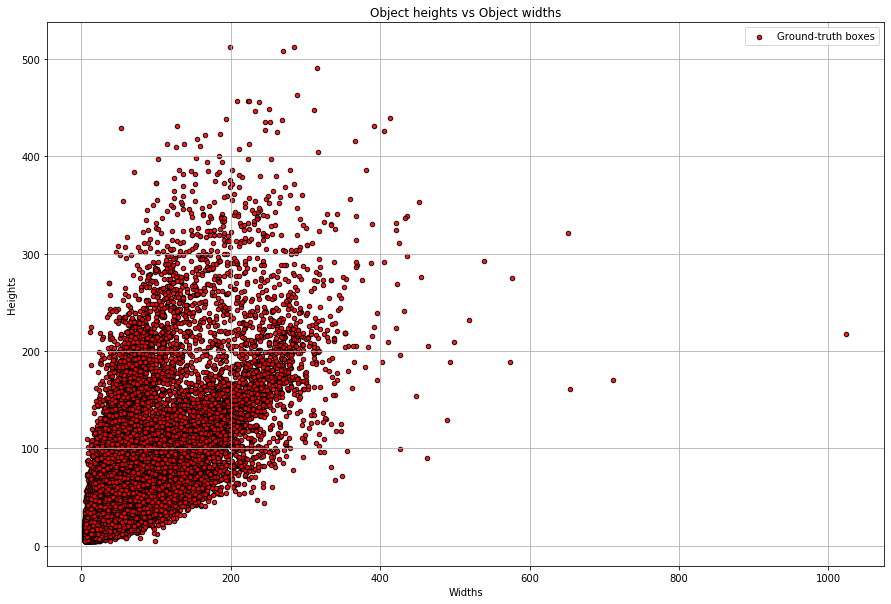

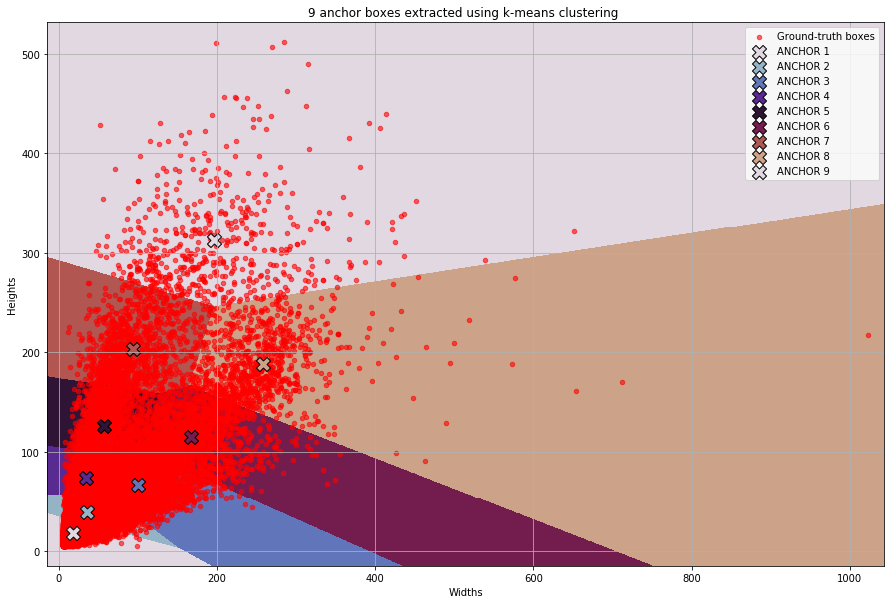

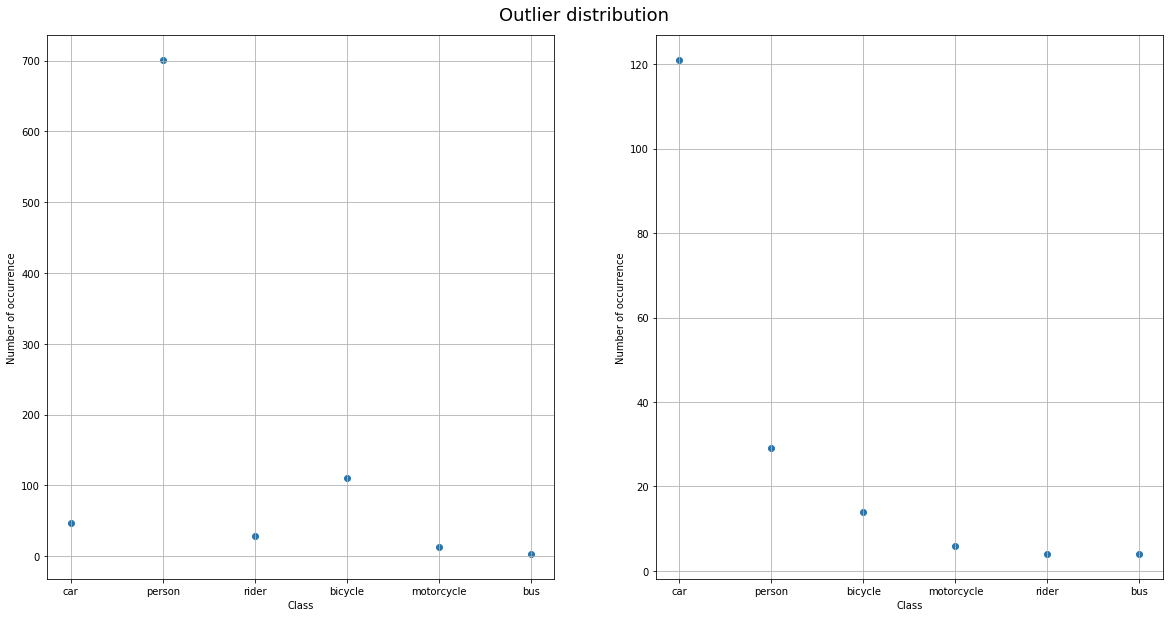

Train: {'car': 47, 'person': 701, 'rider': 28, 'bicycle': 110, 'motorcycle': 13, 'bus': 3} {'car': 121, 'person': 29, 'bicycle': 14, 'motorcycle': 6, 'rider': 4, 'bus': 4}


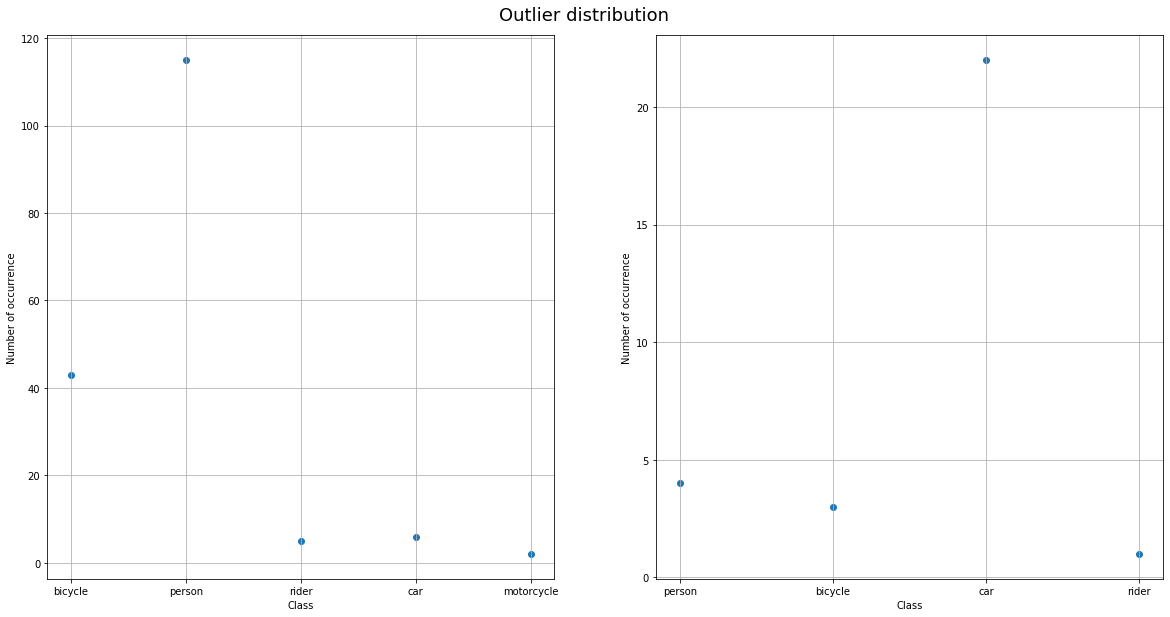

Valid: {'bicycle': 43, 'person': 115, 'rider': 5, 'car': 6, 'motorcycle': 2} {'person': 4, 'bicycle': 3, 'car': 22, 'rider': 1}
(51270, 5)
Min Unscaled Training Width: [  10   10   10 ... 1308 1423 2047]
Min Unscaled Training Height: [  10   10   10 ... 1015 1023 1024]
Min Unscaled Validation Width: [  10   10   10 ...  949  975 1035]
Min Unscaled Validation Height: [ 10  10  10 ... 868 949 982]
(479,) (479,) bus
(582,) (582,) truck
(4738,) (4738,) bicycle
(870,) (870,) motorcycle
(20586,) (20586,) person
(2329,) (2329,) rider
(31648,) (31648,) car


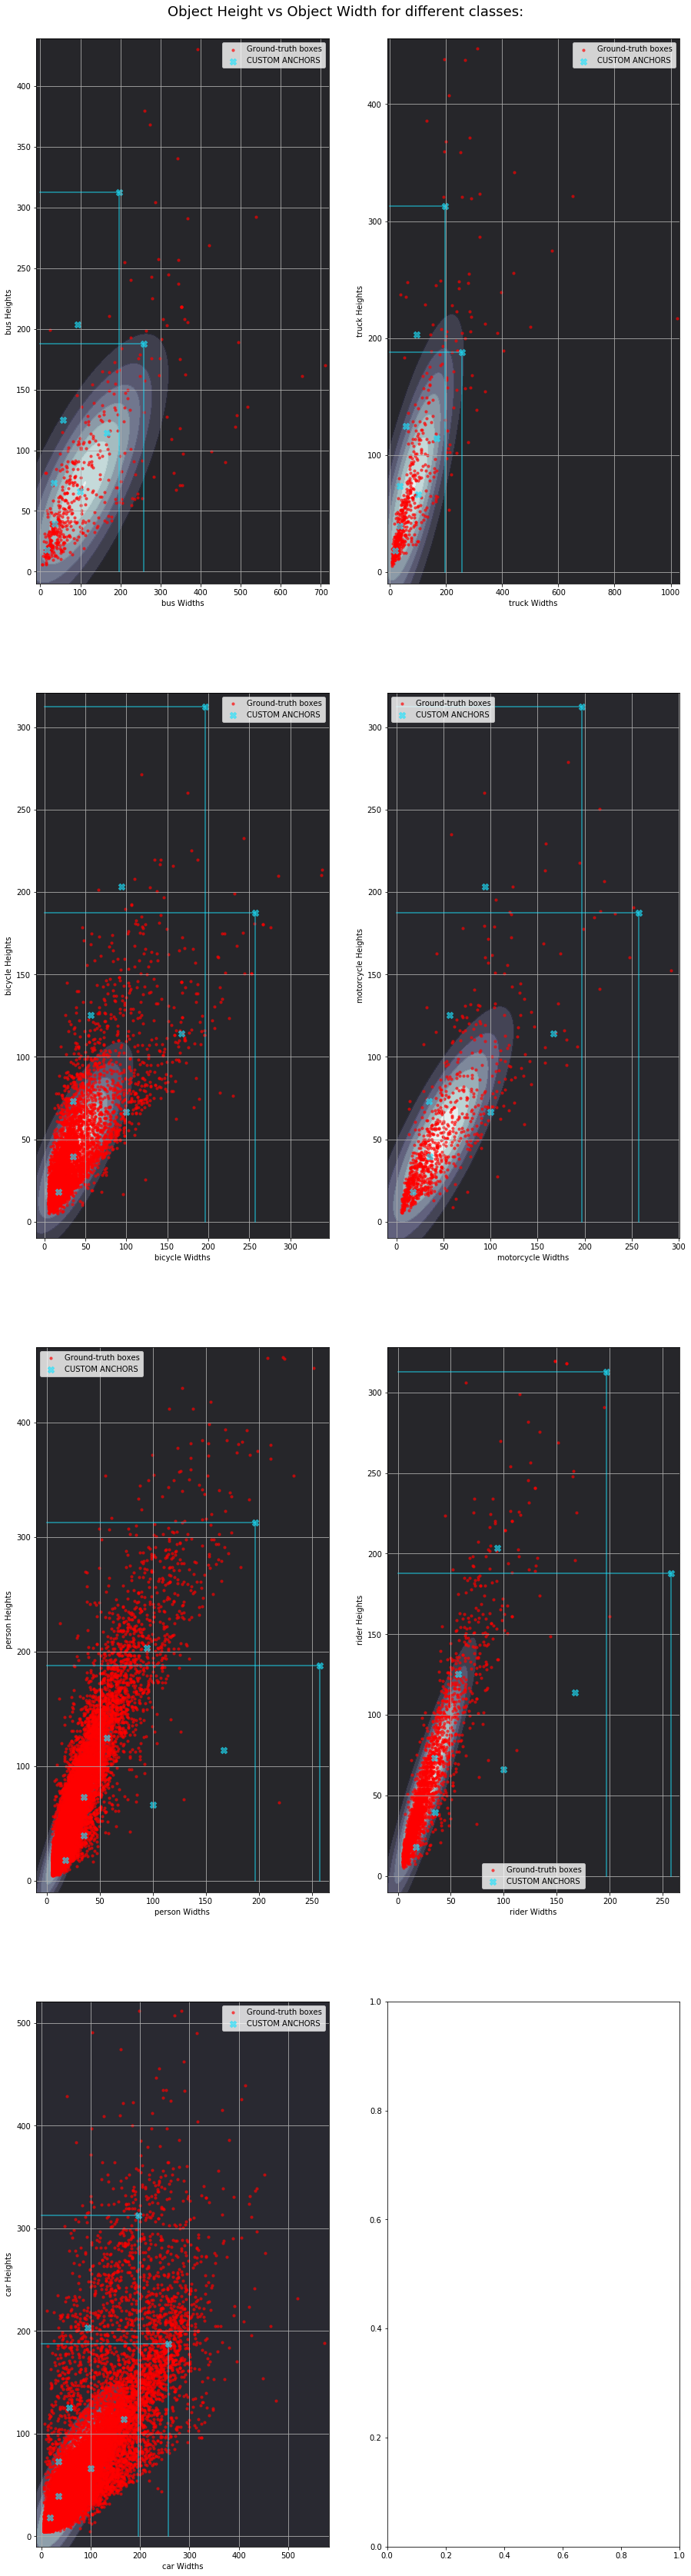

In [9]:
error_list = []
new_anchors, dist1, log_dist = find_anchors(train_total_artifacts1, imgW, imH, 9, 0.5, 0.5)
print(np.round(new_anchors, 2))
error_list.append([dist1, log_dist])
plot_class_profiles(counter_train1, counter_val1, train_total_artifacts1, val_total_artifacts1, 0.5, 0.5, new_anchors)

### KITTI SqueezeDet+ anchors (Resizing the cityscape dataset according to SqueezeDet+ resolution [1242x375])

In [10]:
squeezeDet_plus_anchors = np.array( [[  36.,  37.], [ 366., 174.], [ 115.,  59.],
           [ 162.,  87.], [  38.,  90.], [ 258., 173.],
           [ 224., 108.], [  78., 170.], [  72.,  43.]])
new_anchors, dist1, log_dist = find_anchors(train_total_artifacts1, imgW, imH, 9, 1242/imgW, 375/imH, old_anchors=squeezeDet_plus_anchors)
error_list.append([dist1, log_dist])
# plot_class_profiles(counter_train1, counter_val1, train_total_artifacts1, val_total_artifacts1, 1242/imgW, 375/imH, new_anchors)

Total Distance in log domain: 41943.37352879487
Total Distance: 1303844.217731629


### KITTI SqueezeDet+ anchors (Resizing the cityscape dataset by 2 [1024x512])

In [11]:
squeezeDet_plus_anchors = np.array( [[  36.,  37.], [ 366., 174.], [ 115.,  59.],
           [ 162.,  87.], [  38.,  90.], [ 258., 173.],
           [ 224., 108.], [  78., 170.], [  72.,  43.]])
new_anchors, dist1, log_dist = find_anchors(train_total_artifacts1, imgW, imH, 9, 0.5, 0.5, old_anchors=squeezeDet_plus_anchors)
error_list.append([dist1, log_dist])
# plot_class_profiles(counter_train1, counter_val1, train_total_artifacts1, val_total_artifacts1, 0.5, 0.5, new_anchors)

Total Distance in log domain: 39420.52985183503
Total Distance: 1319528.0976052135


### Downscaling cityscape dataset by 2 [1024x512] and then clustering in log domain

{'car': 47, 'person': 701, 'rider': 28, 'bicycle': 110, 'motorcycle': 13, 'bus': 3} {'car': 121, 'person': 29, 'bicycle': 14, 'motorcycle': 6, 'rider': 4, 'bus': 4}
Before Rescaling [[0.30011915 0.38793783]
 [0.35173377 0.52523404]
 [0.41715314 0.42167137]
 [0.44200799 0.6274122 ]
 [0.49578135 0.51083167]
 [0.54156976 0.7440744 ]
 [0.58006694 0.59996935]
 [0.67542291 0.69510914]
 [0.7420839  0.83382693]]
After Rescaling [[2.08012084 2.4200821 ]
 [2.43786095 3.27658046]
 [2.8912815  2.63052292]
 [3.06355005 3.91400099]
 [3.43625228 3.1867338 ]
 [3.75361103 4.64177765]
 [4.02043436 3.7428036 ]
 [4.681345   4.33631646]
 [5.1433712  5.20168305]]

Extracted Anchors using log domain (in log domain)
[[2.08012084 2.4200821 ]
 [2.43786095 3.27658046]
 [2.8912815  2.63052292]
 [3.06355005 3.91400099]
 [3.43625228 3.1867338 ]
 [3.75361103 4.64177765]
 [4.02043436 3.7428036 ]
 [4.681345   4.33631646]
 [5.1433712  5.20168305]]
Total Distance in log domain: 17299.110129642082

Extracted Anchors usin

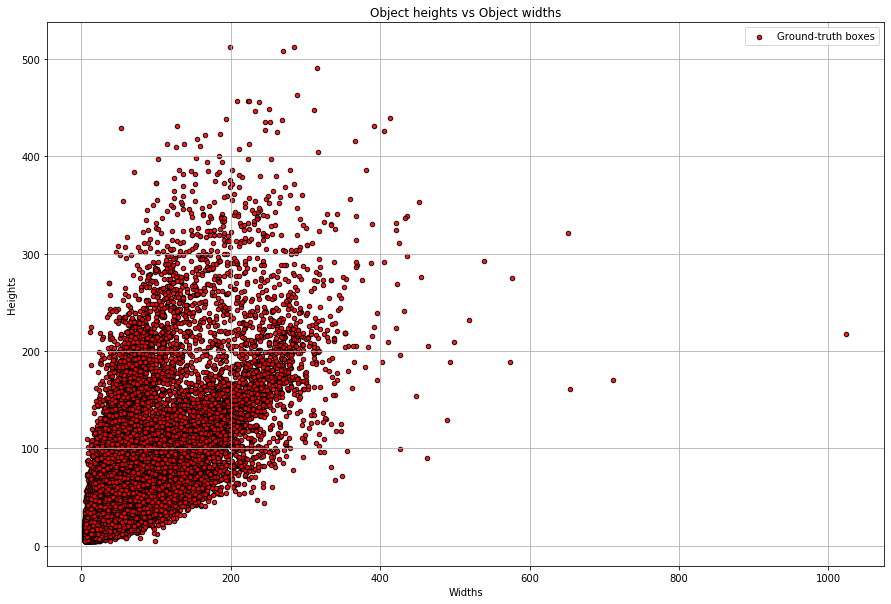

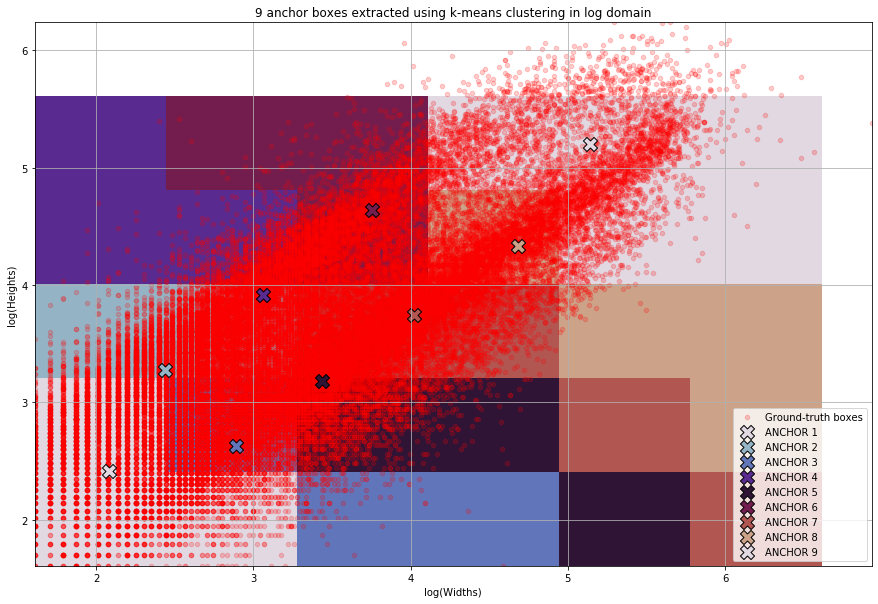

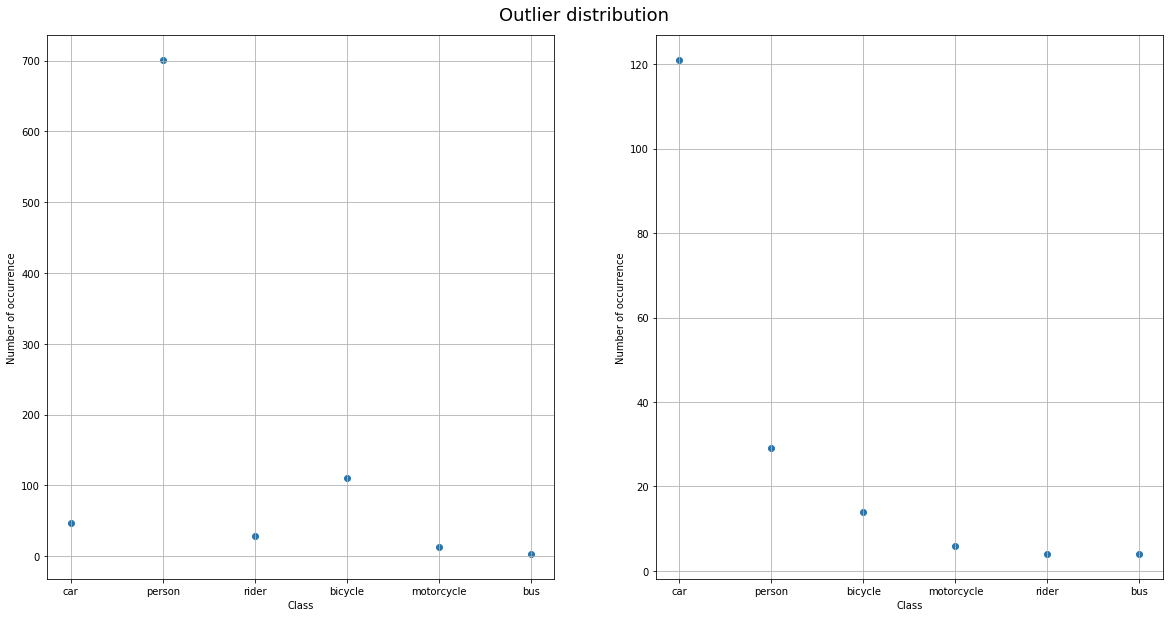

Train: {'car': 47, 'person': 701, 'rider': 28, 'bicycle': 110, 'motorcycle': 13, 'bus': 3} {'car': 121, 'person': 29, 'bicycle': 14, 'motorcycle': 6, 'rider': 4, 'bus': 4}


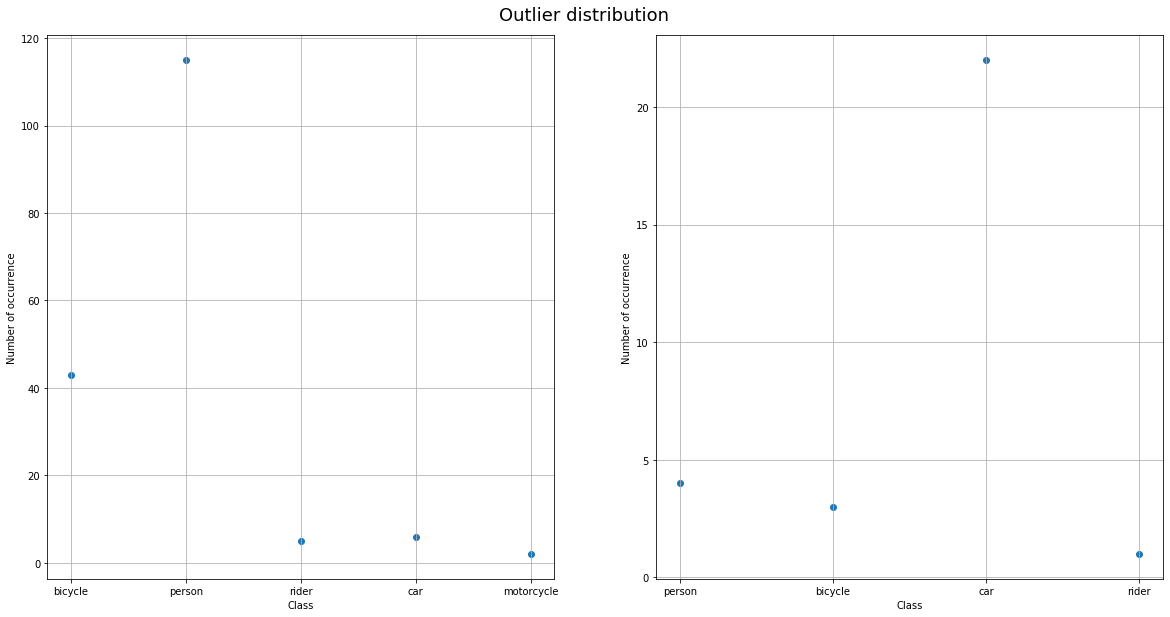

Valid: {'bicycle': 43, 'person': 115, 'rider': 5, 'car': 6, 'motorcycle': 2} {'person': 4, 'bicycle': 3, 'car': 22, 'rider': 1}
(51270, 5)
Min Unscaled Training Width: [  10   10   10 ... 1308 1423 2047]
Min Unscaled Training Height: [  10   10   10 ... 1015 1023 1024]
Min Unscaled Validation Width: [  10   10   10 ...  949  975 1035]
Min Unscaled Validation Height: [ 10  10  10 ... 868 949 982]
(479,) (479,) bus
(582,) (582,) truck
(4738,) (4738,) bicycle
(870,) (870,) motorcycle
(20586,) (20586,) person
(2329,) (2329,) rider
(31648,) (31648,) car


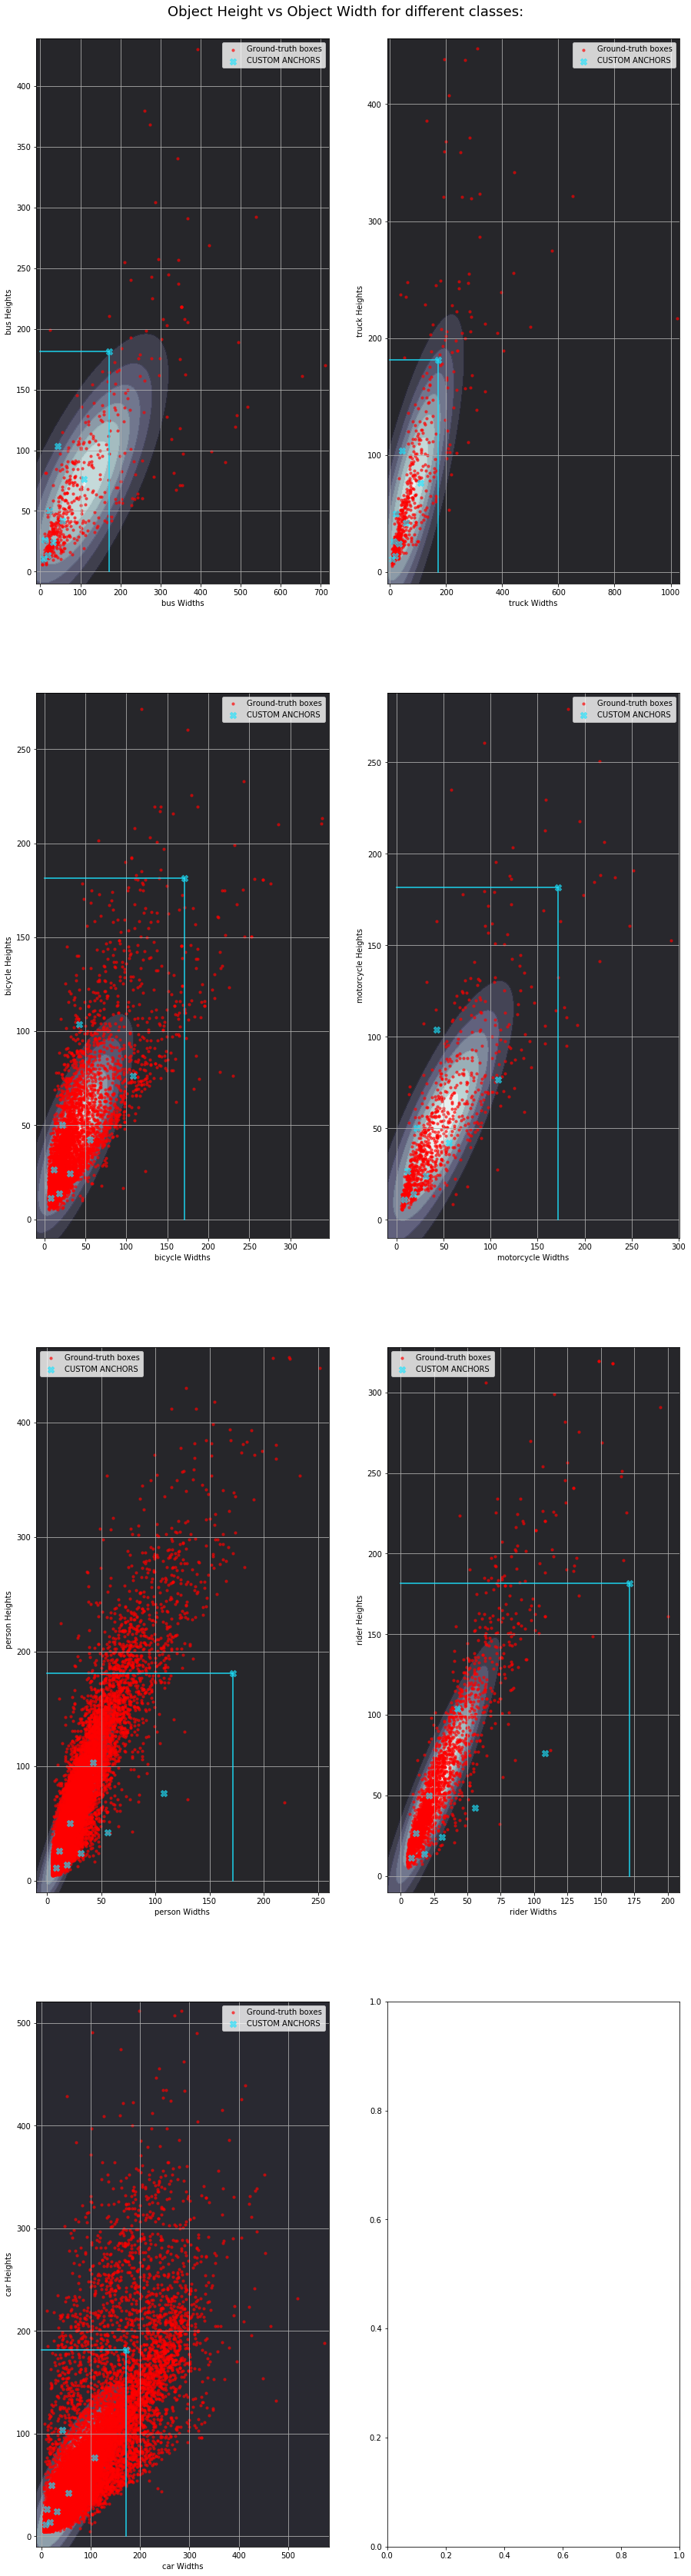

In [12]:
new_anchors, dist1, log_dist = find_anchors_log_domain(train_total_artifacts1, imgW, imH, 9, 0.5, 0.5)
print(np.round(new_anchors, 2))
error_list.append([dist1, log_dist])
plot_class_profiles(counter_train1, counter_val1, train_total_artifacts1, val_total_artifacts1, 0.5, 0.5, new_anchors)

### Plot of spatial distance error and log distance error using different anchor settings

(4, 2)


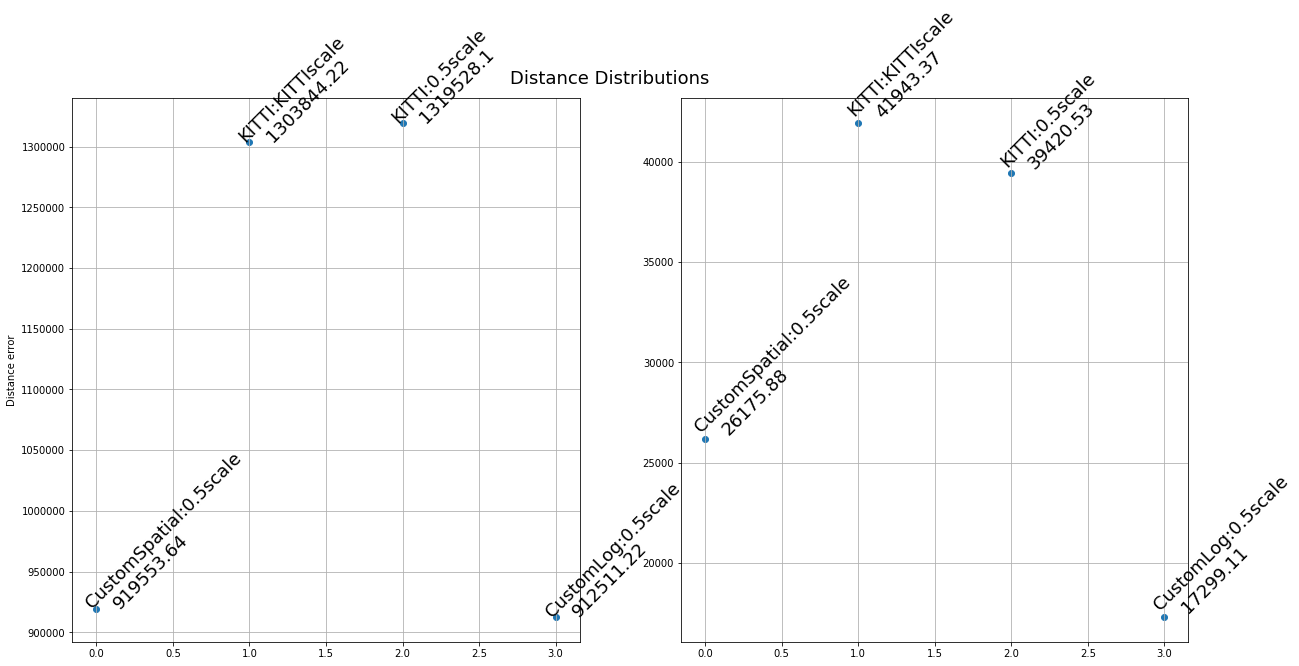

In [13]:
error_list = np.array(error_list)
print(np.shape(error_list))
fig, axs = plt.subplots(1,2,figsize=(20,10))
fig.suptitle('Distance Distributions ', y=0.92, fontsize = 18)
axs[0].scatter(range(len(error_list)), error_list[:,0])
header = ["CustomSpatial:0.5scale", "KITTI:KITTIscale", "KITTI:0.5scale", "CustomLog:0.5scale"]
for i, v in enumerate(error_list[:,0]):
    axs[0].text(i+0.09, v + 250, str(round(v,2)), color='black', rotation=45, fontsize=18)
    axs[0].text(i-0.09, v + 350, header[i], color='black', rotation=45, fontsize=18)
axs[0].set_ylabel('Distance error')
axs[1].scatter(range(len(error_list)), error_list[:,1])
for i, v in enumerate(error_list[:,1]):
    axs[1].text(i+0.09, v + 250, str(round(v,2)), color='black', rotation=45, fontsize=18)
    axs[1].text(i-0.09, v + 350, header[i], color='black', rotation=45, fontsize=18)
axs[0].set_ylabel('Distance error')
axs[1].grid()
axs[0].grid()
plt.show()